# Cart Pole

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Enviroment url: https://gym.openai.com/envs/CartPole-v1/

### Solving requirements: 195 score over 100 episodes

### Enviroment details

- Action space: Discrete with 2 values:

0 - Cart goes to the left

1 - Cart goes to the right

- State space: Box with 4 values:

Cart position

Cart velocity

Pole angle

Pole velocity at tip

- Reward: if enviroment didn't ended $\Rightarrow R_t=1$ 

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import tensorflow as tf
from collections import deque
from IPython.display import clear_output

In [24]:
env = gym.make('CartPole-v1')

## Policy gradient method

In [25]:
class Policy():
    def __init__(self, s_size=4, a_size=2):
        self.w=1e-4*np.random.rand(s_size, a_size)
        self.a_size=a_size
    def prob(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/np.sum(np.exp(x))
    
    def act(self, state):
        prob = self.prob(state)
        action = np.argmax(prob)
        return action

In [26]:
policy = Policy(4, 2)
best_w = policy.w
best_R=-np.inf
noise_scale=1e-2
num_episodes=1000
gamma=1.0
i_episode=0
scores=deque(maxlen=100)
while True:
    i_episode+=1
    rewards=[]
    state=env.reset()
    while True:
        action=policy.act(state)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        state=next_state
        if done:
            break
    scores.append(np.sum(rewards))
    discounts=[gamma**i for i in range(len(rewards)+1)]
    R=np.sum([a*b for a,b in zip(rewards, discounts)])
    if R>=best_R:
        best_R=R
        best_w=policy.w
        noise_scale = max(1e-3, noise_scale/2)
        policy.w += noise_scale*np.random.rand(*policy.w.shape)
    else:
        noise_scale = min(2, noise_scale*2)
        policy.w = best_w + noise_scale*np.random.rand(*policy.w.shape)
    clear_output(True)
    print('Episode : {}/{} ... score : {}'.format(i_episode, num_episodes, np.mean(scores))) 
    if i_episode>=num_episodes:
        break

Episode : 1000/1000 ... score : 500.0


In [36]:
class QNetwork():
    def __init__(self, state_size, hidden_size, action_size,learning_rate=0.01, name='QNetwork'):
        
        with tf.variable_scope(name): 
            self.inputs_ = tf.placeholder(dtype=tf.float32, shape=[None, state_size], name='inputs')
            
            self.actions_ = tf.placeholder(dtype=tf.int32, shape=[None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            self.targetQs_ = tf.placeholder(dtype=tf.float32, shape=[None], name='target') 
            
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, num_outputs=hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, num_outputs=hidden_size)
            
            self.output = tf.contrib.layers.fully_connected(self.fc2, num_outputs=action_size, activation_fn=None)
            
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            
            self.opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)

In [37]:
class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        
        return [self.buffer[ii] for ii in idx]

In [38]:
tf.reset_default_graph()

In [39]:
QAgent = QNetwork(name='network', hidden_size=64, learning_rate=0.0001, action_size=2, state_size=4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [41]:
env.reset()

state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=1000)

for ii in range(20):
    
    action = env.action_space.sample()
    
    next_state, reward, done, _ = env.step(action)
    
    if done:
        
        next_state = np.zeros(state.shape)
        
        memory.add((state, action, reward, next_state))
        
        env.reset()
        
        state, reward, done, _ = env.step(env.action_space.sample())
        
    else:
        
        memory.add((state, action, reward, next_state))
        
        state = next_state

In [57]:
epsilon_max = 1.0
epsilon_min = 0.001
epsilon_decay = 0.0005

saver = tf.train.Saver()

rewards_list = []

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    step = 0
    
    for ep in range(1,1000):
        total_reward = 0
        t = 0
        
        while True:
            step+=1
            
            epsilon = epsilon_min + (epsilon_max-epsilon_min)*np.exp(-epsilon_decay*step)
            
            if epsilon > np.random.rand():
                action = env.action_space.sample()
                
            else:
                
                feed = {QAgent.inputs_: state.reshape((1, *state.shape))}
                Q_s = sess.run(QAgent.output, feed_dict = feed)
                action = np.argmax(Q_s)
                
            next_state, reward, done, _ = env.step(action)
            
            total_reward +=reward
            
            if done:
                
                next_state = np.zeros(state.shape)
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(epsilon))
                rewards_list.append((ep, total_reward))
                
                memory.add((state, action, reward, next_state))
                
                env.reset()
                
                state, reward, done, _ = env.step(env.action_space.sample())
                break
                
            else:
                
                memory.add((state, action, reward, next_state))
                state = next_state

                
            batch = memory.sample(batch_size=20)
            
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            target_Qs = sess.run(QAgent.output, feed_dict={QAgent.inputs_ : next_states})
            
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0,0)
            
            targets = reward + 0.99*np.max(target_Qs, axis=1)
            
            loss, _ = sess.run([QAgent.loss, QAgent.opt], feed_dict={
                QAgent.inputs_ : states,
                QAgent.targetQs_ : targets,
                QAgent.actions_ : actions
            })
            
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 9.0 Training loss: 1.0730 Explore P: 0.9955
Episode: 2 Total reward: 23.0 Training loss: 1.0362 Explore P: 0.9841
Episode: 3 Total reward: 10.0 Training loss: 1.1003 Explore P: 0.9792
Episode: 4 Total reward: 12.0 Training loss: 1.1057 Explore P: 0.9734
Episode: 5 Total reward: 14.0 Training loss: 0.9941 Explore P: 0.9666
Episode: 6 Total reward: 26.0 Training loss: 1.0458 Explore P: 0.9541
Episode: 7 Total reward: 17.0 Training loss: 1.0956 Explore P: 0.9461
Episode: 8 Total reward: 22.0 Training loss: 1.1050 Explore P: 0.9357
Episode: 9 Total reward: 21.0 Training loss: 1.1844 Explore P: 0.9260
Episode: 10 Total reward: 11.0 Training loss: 1.1234 Explore P: 0.9209
Episode: 11 Total reward: 15.0 Training loss: 1.2404 Explore P: 0.9140
Episode: 12 Total reward: 10.0 Training loss: 1.2378 Explore P: 0.9095
Episode: 13 Total reward: 10.0 Training loss: 1.2666 Explore P: 0.9049
Episode: 14 Total reward: 27.0 Training loss: 1.2470 Explore P: 0.8928
Episode: 15 Tota

Episode: 117 Total reward: 13.0 Training loss: 3.7234 Explore P: 0.4401
Episode: 118 Total reward: 24.0 Training loss: 26.2979 Explore P: 0.4349
Episode: 119 Total reward: 14.0 Training loss: 10.8814 Explore P: 0.4318
Episode: 120 Total reward: 10.0 Training loss: 28.0934 Explore P: 0.4297
Episode: 121 Total reward: 11.0 Training loss: 3.6315 Explore P: 0.4273
Episode: 122 Total reward: 10.0 Training loss: 26.6993 Explore P: 0.4252
Episode: 123 Total reward: 13.0 Training loss: 23.3092 Explore P: 0.4225
Episode: 124 Total reward: 19.0 Training loss: 22.2183 Explore P: 0.4185
Episode: 125 Total reward: 9.0 Training loss: 3.0465 Explore P: 0.4166
Episode: 126 Total reward: 8.0 Training loss: 18.1069 Explore P: 0.4150
Episode: 127 Total reward: 9.0 Training loss: 9.8307 Explore P: 0.4131
Episode: 128 Total reward: 11.0 Training loss: 9.7501 Explore P: 0.4108
Episode: 129 Total reward: 15.0 Training loss: 2.8931 Explore P: 0.4078
Episode: 130 Total reward: 12.0 Training loss: 16.5496 Explo

Episode: 233 Total reward: 14.0 Training loss: 1.8899 Explore P: 0.2179
Episode: 234 Total reward: 16.0 Training loss: 2.4324 Explore P: 0.2161
Episode: 235 Total reward: 12.0 Training loss: 2.8403 Explore P: 0.2148
Episode: 236 Total reward: 13.0 Training loss: 3.1737 Explore P: 0.2135
Episode: 237 Total reward: 16.0 Training loss: 6.2838 Explore P: 0.2118
Episode: 238 Total reward: 14.0 Training loss: 2.3720 Explore P: 0.2103
Episode: 239 Total reward: 11.0 Training loss: 6.3108 Explore P: 0.2091
Episode: 240 Total reward: 14.0 Training loss: 4.4746 Explore P: 0.2077
Episode: 241 Total reward: 16.0 Training loss: 3.8690 Explore P: 0.2061
Episode: 242 Total reward: 12.0 Training loss: 0.5674 Explore P: 0.2048
Episode: 243 Total reward: 14.0 Training loss: 3.1013 Explore P: 0.2034
Episode: 244 Total reward: 14.0 Training loss: 2.9629 Explore P: 0.2020
Episode: 245 Total reward: 9.0 Training loss: 3.3901 Explore P: 0.2011
Episode: 246 Total reward: 17.0 Training loss: 4.5495 Explore P: 

Episode: 347 Total reward: 10.0 Training loss: 5.1328 Explore P: 0.0937
Episode: 348 Total reward: 13.0 Training loss: 14.7061 Explore P: 0.0931
Episode: 349 Total reward: 11.0 Training loss: 5.1014 Explore P: 0.0926
Episode: 350 Total reward: 12.0 Training loss: 9.9143 Explore P: 0.0921
Episode: 351 Total reward: 10.0 Training loss: 9.6691 Explore P: 0.0916
Episode: 352 Total reward: 12.0 Training loss: 1.0526 Explore P: 0.0911
Episode: 353 Total reward: 8.0 Training loss: 8.3015 Explore P: 0.0907
Episode: 354 Total reward: 8.0 Training loss: 9.0311 Explore P: 0.0904
Episode: 355 Total reward: 17.0 Training loss: 9.7740 Explore P: 0.0896
Episode: 356 Total reward: 13.0 Training loss: 7.0710 Explore P: 0.0890
Episode: 357 Total reward: 12.0 Training loss: 3.6471 Explore P: 0.0885
Episode: 358 Total reward: 8.0 Training loss: 4.4886 Explore P: 0.0882
Episode: 359 Total reward: 10.0 Training loss: 7.5491 Explore P: 0.0877
Episode: 360 Total reward: 9.0 Training loss: 4.4814 Explore P: 0.

Episode: 470 Total reward: 11.0 Training loss: 0.9594 Explore P: 0.0397
Episode: 471 Total reward: 9.0 Training loss: 14.6869 Explore P: 0.0395
Episode: 472 Total reward: 11.0 Training loss: 1.3689 Explore P: 0.0393
Episode: 473 Total reward: 11.0 Training loss: 22.6821 Explore P: 0.0391
Episode: 474 Total reward: 15.0 Training loss: 23.1423 Explore P: 0.0388
Episode: 475 Total reward: 9.0 Training loss: 6.2993 Explore P: 0.0386
Episode: 476 Total reward: 12.0 Training loss: 5.9962 Explore P: 0.0384
Episode: 477 Total reward: 10.0 Training loss: 16.7061 Explore P: 0.0382
Episode: 478 Total reward: 12.0 Training loss: 5.3327 Explore P: 0.0380
Episode: 479 Total reward: 11.0 Training loss: 9.6661 Explore P: 0.0378
Episode: 480 Total reward: 9.0 Training loss: 0.8523 Explore P: 0.0376
Episode: 481 Total reward: 9.0 Training loss: 5.1161 Explore P: 0.0375
Episode: 482 Total reward: 11.0 Training loss: 8.8843 Explore P: 0.0373
Episode: 483 Total reward: 7.0 Training loss: 1.3012 Explore P: 

Episode: 586 Total reward: 14.0 Training loss: 17.1781 Explore P: 0.0186
Episode: 587 Total reward: 15.0 Training loss: 1.2962 Explore P: 0.0185
Episode: 588 Total reward: 16.0 Training loss: 17.5360 Explore P: 0.0183
Episode: 589 Total reward: 13.0 Training loss: 10.8348 Explore P: 0.0182
Episode: 590 Total reward: 16.0 Training loss: 1.1357 Explore P: 0.0181
Episode: 591 Total reward: 14.0 Training loss: 6.8345 Explore P: 0.0179
Episode: 592 Total reward: 10.0 Training loss: 9.3290 Explore P: 0.0179
Episode: 593 Total reward: 16.0 Training loss: 3.7276 Explore P: 0.0177
Episode: 594 Total reward: 12.0 Training loss: 18.2558 Explore P: 0.0176
Episode: 595 Total reward: 14.0 Training loss: 0.5257 Explore P: 0.0175
Episode: 596 Total reward: 10.0 Training loss: 1.5064 Explore P: 0.0174
Episode: 597 Total reward: 9.0 Training loss: 5.2314 Explore P: 0.0174
Episode: 598 Total reward: 8.0 Training loss: 18.6117 Explore P: 0.0173
Episode: 599 Total reward: 10.0 Training loss: 1.3234 Explore

Episode: 700 Total reward: 22.0 Training loss: 1.9052 Explore P: 0.0049
Episode: 701 Total reward: 30.0 Training loss: 59.8830 Explore P: 0.0048
Episode: 702 Total reward: 21.0 Training loss: 30.6745 Explore P: 0.0048
Episode: 703 Total reward: 23.0 Training loss: 52.9744 Explore P: 0.0047
Episode: 704 Total reward: 26.0 Training loss: 30.6665 Explore P: 0.0047
Episode: 705 Total reward: 21.0 Training loss: 1.0410 Explore P: 0.0047
Episode: 706 Total reward: 18.0 Training loss: 1.1623 Explore P: 0.0046
Episode: 707 Total reward: 14.0 Training loss: 1.7231 Explore P: 0.0046
Episode: 708 Total reward: 21.0 Training loss: 0.7741 Explore P: 0.0046
Episode: 709 Total reward: 27.0 Training loss: 24.7979 Explore P: 0.0045
Episode: 710 Total reward: 30.0 Training loss: 0.6657 Explore P: 0.0045
Episode: 711 Total reward: 23.0 Training loss: 26.7090 Explore P: 0.0044
Episode: 712 Total reward: 22.0 Training loss: 21.9735 Explore P: 0.0044
Episode: 713 Total reward: 28.0 Training loss: 1.0560 Exp

Episode: 814 Total reward: 103.0 Training loss: 0.3333 Explore P: 0.0011
Episode: 815 Total reward: 104.0 Training loss: 0.2374 Explore P: 0.0011
Episode: 816 Total reward: 98.0 Training loss: 12.6380 Explore P: 0.0011


KeyboardInterrupt: 

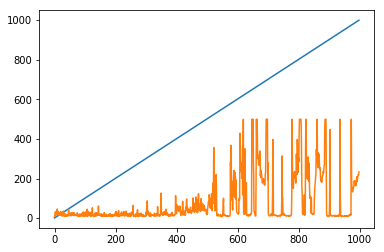

In [54]:
plt.plot(rewards_list)